In [1]:
!pip install transformers

In [2]:

# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
logging.basicConfig(level=logging.ERROR)
device = 'cuda' if cuda.is_available() else 'cpu'


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Load dataset
df_org = pd.read_csv('/content/drive/MyDrive/LLM Research Lab/dataset/dataset-2344.csv')
df_org.head()


,Unnamed: 0,title,content,time,category,subreddit,score,upvote_ratio
0,0,STOP EVERYTHING! ​Is Will & Grace returning af...,Will & Grace taught us many lessons in life – ...,2016-09-26 07:16:00+00:00,misleading content,savedyouaclick,4370.0,NaN
1,1,Florida county commissioner limited vaccine dr...,"CNN — A Manatee County, Florida, commissioner...",2021-02-18 00:00:00,True,neutralnews,468.0,0.97
2,2,"Black Mirror season 6 cast, trailer, release d...",Who is in the Black Mirror season 6 cast? For ...,NaN,misleading content,savedyouaclick,2822.0,0.99
3,3,What's the difference between a Ralph Lauren P...,"Hey, I've been eyeing the RL Polo Polo Ralph...",NaN,imposter content,subsimulatorgpt2,912.0,NaN
4,4,David Beckham Joins Queue To Pay Respects To Bród,David Beckham Joins Queue To Pay Respects To B...,2023-04-24,satire,waterfordwhispersnews,15.0,1.00


In [5]:
category_mapping = {
    'True': 0,
    'satire': 1,
    'misleading content': 2,
    'imposter content': 3
}

In [6]:
df_input= pd.DataFrame()
df_input['content'] = df_org['title'] + '\n'  + df_org['content']
df_input['category'] = df_org['category'].map(category_mapping)
df_input.head()

,content,category
0,STOP EVERYTHING! ​Is Will & Grace returning af...,2
1,Florida county commissioner limited vaccine dr...,0
2,"Black Mirror season 6 cast, trailer, release d...",2
3,What's the difference between a Ralph Lauren P...,3
4,David Beckham Joins Queue To Pay Respects To B...,1


   category  count
0         1    753
1         0    661
2         3    538
3         2    392


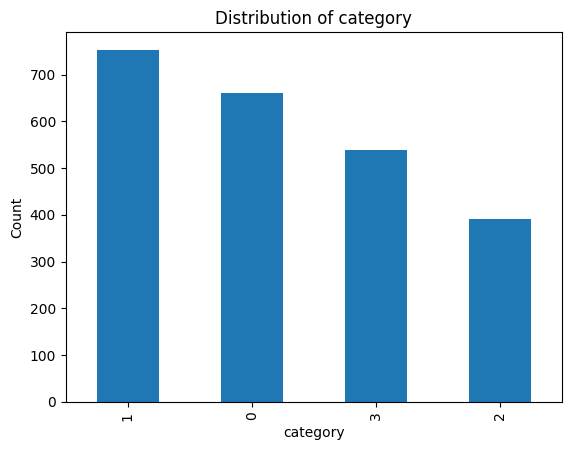

In [7]:
category_column = 'category'


# Show the category-wise distribution
distribution = df_input[category_column].value_counts().reset_index()
distribution.columns = [category_column, 'count']

print(distribution)

# Plot the distribution as a bar chart


distribution.plot(kind='bar', x=category_column, y='count', legend=False)
plt.title(f'Distribution of {category_column}')
plt.xlabel(category_column)
plt.ylabel('Count')
plt.show()

In [8]:

# Define key variables
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.content
        self.targets = self.data.category
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        if index >= len(self.data):
          raise IndexError("Index out of range")
        text = str(self.text[index])
        text = " ".join(text.split())

        text_inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        text_ids = text_inputs['input_ids']
        text_mask = text_inputs['attention_mask']
        text_token_type_ids = text_inputs["token_type_ids"]



        return {
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [10]:

# Split the dataset
train_data, test_data = train_test_split(df_input, test_size=0.2, stratify=df_input['category'])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


In [11]:

# Prepare dataloaders
train_dataset = SentimentData(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SentimentData(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)


In [12]:

# Define model training and evaluation functions
def train_model(model, train_loader, epochs):
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss = 0
        for _, data in tqdm(enumerate(train_loader, 0)):
            text_ids = data['text_ids'].to(device, dtype=torch.long)
            text_mask = data['text_mask'].to(device, dtype=torch.long)
            text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            ).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()




In [13]:
# def evaluate_model(model, test_loader, test_data):
#     model.eval()
#     predictions = []
#     with torch.no_grad():
#         for _, data in tqdm(enumerate(test_loader, 0)):
#             text_ids = data['text_ids'].to(device, dtype=torch.long)
#             text_mask = data['text_mask'].to(device, dtype=torch.long)
#             text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)
#             outputs = model(
#                 text_ids=text_ids,
#                 text_mask=text_mask,
#                 text_token_type_ids=text_token_type_ids
#             ).squeeze()
#             big_val, big_idx = torch.max(outputs.data, dim=1)
#             predictions.extend(big_idx.cpu().numpy())

#     test_data['predicted_category'] = predictions
#     return test_data

In [19]:
def evaluate_model(model, test_loader, test_data):
    predictions = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            text_ids = data['text_ids'].to(device, dtype=torch.long)
            text_mask = data['text_mask'].to(device, dtype=torch.long)
            text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)

            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            ) # Removed squeeze() as it is likely flattening the output to a single dimension
            # Check the shape of the output to confirm
            print("Shape of outputs:", outputs.shape)

            # If outputs is 2D, proceed with finding max
            if len(outputs.shape) == 2:
                big_val, big_idx = torch.max(outputs.data, dim=1)
                predictions.extend(big_idx.cpu().numpy())
            else:
                print("Model output is not 2D. Check model architecture.")

    test_data['predictions'] = predictions
    return test_data

In [14]:

# Define the evaluation function
def evaluate(y_true, y_pred):
    labels = ['TRUE', 'satire', 'misleading content', 'imposter content', 'none']
    mapping = {'TRUE': 1, 'satire': 2, 'misleading content': 3, 'imposter content': 4, 'none': 5}

    def map_func(x):
        return mapping.get(x, 5)

    # y_true = np.vectorize(map_func)(y_true)
    # y_pred = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    unique_labels = set(y_true)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4])
    print('\nConfusion Matrix:')
    print(conf_matrix)


In [15]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)  # Adjusted for combined inputs
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, text_ids, text_mask, text_token_type_ids):
        text_output = self.l1(input_ids=text_ids, attention_mask=text_mask, token_type_ids=text_token_type_ids)


        text_hidden_state = text_output[0]

        pooler = text_hidden_state[:, 0]

        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [16]:

# Initialize model
model = RobertaClass()
model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [17]:
# Train and evaluate
train_model(model, train_loader, EPOCHS)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
469it [00:53,  8.70it/s]


In [20]:
test_data_with_predictions = evaluate_model(model, test_loader, test_data)
test_data_with_predictions.head()

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
4it [00:00, 32.43it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


13it [00:00, 37.25it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


24it [00:00, 44.93it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


34it [00:00, 38.06it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


45it [00:01, 44.21it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


55it [00:01, 46.03it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


67it [00:01, 51.96it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


79it [00:01, 51.45it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


85it [00:01, 51.54it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


96it [00:02, 47.65it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


108it [00:02, 50.09it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


120it [00:02, 50.95it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


132it [00:02, 50.92it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


144it [00:03, 52.68it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


150it [00:03, 52.47it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


161it [00:03, 47.59it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


173it [00:03, 50.91it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


185it [00:03, 51.26it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


197it [00:04, 52.68it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


209it [00:04, 51.31it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


215it [00:04, 50.91it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


226it [00:04, 45.55it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


235it [00:04, 47.62it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([1, 5])


,content,category,predictions
0,Putin Reaching ‘End Of Goodfellas’ Levels Of P...,1,2
1,Republicans block cap on insulin costs for mil...,0,0
2,She sliced a man's throat in a graveyard. He l...,2,3
3,Trump posts nearly $92 million bond in E. Jean...,0,2
4,Ohio Republicans Say It’s Their ‘God Given Rig...,0,0


In [ ]:
test_data_with_predictions.head()

In [22]:
# Evaluate the results
evaluate(test_data_with_predictions['category'], test_data_with_predictions['predictions'])

Accuracy: 0.269
Accuracy for label 0: 0.303
Accuracy for label 1: 0.351
Accuracy for label 2: 0.090
Accuracy for label 3: 0.241

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.30      0.29       132
           1       0.36      0.35      0.35       151
           2       0.10      0.09      0.09        78
           3       0.24      0.24      0.24       108

    accuracy                           0.27       469
   macro avg       0.24      0.25      0.25       469
weighted avg       0.27      0.27      0.27       469


Confusion Matrix:
[[40 39 21 32  0]
 [44 53 25 29  0]
 [30 18  7 23  0]
 [26 38 18 26  0]
 [ 0  0  0  0  0]]
